# Connected Component Labelling and Analysis
Connected component labeling (also known as connected component analysis, blob extraction, or region labeling) is an algorithmic application of graph theory used to determine the connectivity of “blob”-like regions in a binary image.

We often use connected component analysis in the same situations that contours are used; however, connected component labeling can often give us more granular filtering of the blobs in a binary image.

A blob refers to a region in an image that is visually distinct from its surrounding areas based on certain properties, such as brightness, color, or texture.Blobs are typically areas that are either brighter or darker than the surrounding regions and can represent various features like edges, corners, or specific objects within an image.

When using contour analysis, we are often restricted by the hierarchy of the outlines (i.e., one contour contained within another). With connected component analysis, we can more easily segment and analyze these structures.

A great example of connected component analysis is computing the connected components of a binary (i.e., thresholded) license plate image and filtering the blobs based on their properties (e.g., width, height, area, solidity, etc.). This is exactly what we’ll be doing here today.

## 1. Implementing basic connected components with OpenCV

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img_path = 'images/number_plate.jpg'

In [4]:
# load the input image from disk, convert it to grayscale, and
# threshold it
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

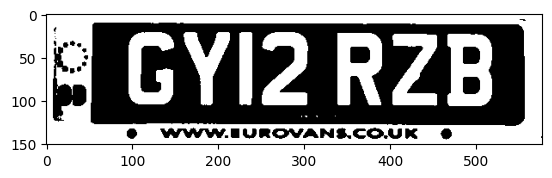

In [5]:
plt.imshow(thresh, cmap='gray')

In [6]:
# apply connected component analysis to the thresholded image
connectivity = 8
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

In [7]:
# initialize an output mask to store all characters parsed from
# the license plate
mask = np.zeros(gray.shape, dtype="uint8")

In [8]:
numLabels

17

In [9]:
stats.shape

(17, 5)

In [10]:
labels.shape

(151, 577)

In [11]:
centroids.shape

(17, 2)

In [12]:
# loop over the number of unique connected component labels
for i in range(0, numLabels):
	# if this is the first component then we examine the
	# *background* (typically we would just ignore this
	# component in our loop)
	if i == 0:
		text = "examining component {}/{} (background)".format(
			i + 1, numLabels)
	# otherwise, we are examining an actual connected component
	else:
		text = "examining component {}/{}".format( i + 1, numLabels)
	# print a status message update for the current connected
	# component
	print("[INFO] {}".format(text))
	# extract the connected component statistics and centroid for
	# the current label
	x = stats[i, cv2.CC_STAT_LEFT]
	y = stats[i, cv2.CC_STAT_TOP]
	w = stats[i, cv2.CC_STAT_WIDTH]
	h = stats[i, cv2.CC_STAT_HEIGHT]
	area = stats[i, cv2.CC_STAT_AREA]
	(cX, cY) = centroids[i]
    # clone our original image (so we can draw on it) and then draw
	# a bounding box surrounding the connected component along with
	# a circle corresponding to the centroid
	output = image.copy()
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
	cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    # construct a mask for the current connected component by
	# finding a pixels in the labels array that have the current
	# connected component ID
	componentMask = (labels == i).astype("uint8") * 255
	# show our output image and connected component mask
	cv2.imshow("Output", output)
	cv2.imshow("Connected Component", componentMask)
	# Wait for the "q" key to be pressed
	while True:
		# Wait for 1 ms and check if the key pressed is "q"
		if cv2.waitKey(1) & 0xFF == ord('q'):
			break

# Close all OpenCV windows
cv2.destroyAllWindows()

[INFO] examining component 1/17 (background)


QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread

[INFO] examining component 2/17
[INFO] examining component 3/17
[INFO] examining component 4/17
[INFO] examining component 5/17
[INFO] examining component 6/17
[INFO] examining component 7/17
[INFO] examining component 8/17
[INFO] examining component 9/17
[INFO] examining component 10/17
[INFO] examining component 11/17
[INFO] examining component 12/17
[INFO] examining component 13/17
[INFO] examining component 14/17
[INFO] examining component 15/17
[INFO] examining component 16/17
[INFO] examining component 17/17


## 2. How to filter connected components with OpenCV

In [13]:
# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background)
for i in range(1, numLabels):
    # extract the connected component statistics for the current
    # label
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    
    # ensure the width, height, and area are all neither too small
    # nor too big
    keepWidth = w > 5 and w < 55
    keepHeight = h > 45 and h < 86
    keepArea = area > 500 and area < 3200
    # ensure the connected component we are examining passes all
    # three tests
    if all((keepWidth, keepHeight, keepArea)):
        # construct a mask for the current connected component and
        # then take the bitwise OR with the mask
        print("[INFO] keeping connected component '{}'".format(i))
        componentMask = (labels == i).astype("uint8") * 255
        mask = cv2.bitwise_or(mask, componentMask)
        # show the original input image and the mask for the license plate
        cv2.imshow("Image", image)
        cv2.imshow("Characters", mask)
        
        # Wait for the "q" key to be pressed
        while True:
            # Wait for 1 ms and check if the key pressed is "q"
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
# Close all OpenCV windows
cv2.destroyAllWindows()

[INFO] keeping connected component '2'


QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread (0x2b9df10).
Cannot move to target thread (0x284d810)

QObject::moveToThread: Current thread (0x284d810) is not the object's thread

[INFO] keeping connected component '3'
[INFO] keeping connected component '4'
[INFO] keeping connected component '5'
[INFO] keeping connected component '6'
[INFO] keeping connected component '7'
